# Data collection - Web scraping (data collection) 

In [ ]:
# -*- coding: utf-8 -*- 
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd

CSV = 'cars.csv'
HOST = 'https://kolesa.kz/'
URL = 'https://kolesa.kz/cars/avtomobili-s-probegom/'
HEADERS = {
	'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
	'user-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36'
}

def get_html(url, params=''):
    r = requests.get(url, headers=HEADERS, params=params)
    return r

def content(html):
    soup = BeautifulSoup(html, 'html.parser')
    # information about cars on the site is divided into three classes, respectively, you need to use the appropriate items to collect data
    items_1 = soup.find_all('div', class_='row vw-item list-item a-elem') #regular ad
    items_2 = soup.find_all('div', class_='row vw-item list-item yellow a-elem') #yellow ad
    items_3= soup.find_all('div', class_='row vw-item list-item blue a-elem') #blue ad
    
    items = [items_1,items_2, items_3]
    cars = []
    
    # loop to loop through three items separately 
    for item in items:
        # loop to loop through the elements of the corresponding item in the cut of each item
        for sub_item in item:
            # use try except to avoid possible errors when collecting data, in case of an error, skip the current one
            # iterate and continue with next iteration
            try:
                # It is necessary to separate the text information and among them to collect some key characteristics of the cars
                length = len(sub_item.find('div', class_='a-search-description').get_text(strip=True).split(','))
                for i in range(length):
                    # In order to get information about the checkpoint, the keyword is used
                    if 'КПП' in sub_item.find('div', class_='a-search-description').get_text(strip=True).split(',')[i]:
                        index = i
                # the array is filled with different characteristics of the machines at each iteration
                cars.append(
                   {
                'title':sub_item.find('span', class_='a-el-info-title').get_text(strip=True),
                #'link':HOST + sub_item.find('span', class_='a-el-info-title').find('a').get('href'),
                'price ₸':sub_item.find('span', class_='price').get_text(strip=True).replace("\n","").replace(" ","").replace(u'\xa0', u'').replace("₸",""),
                #'car_img':sub_item.find('picture').find('img').get('src'),
                'year of issue':sub_item.find('div', class_='a-search-description').get_text(strip=True).split(',')[0],
                'engine vol':sub_item.find('div', class_='a-search-description').get_text(strip=True).split(',')[2],
                'engine type':sub_item.find('div', class_='a-search-description').get_text(strip=True).split(',')[3],
                'gear type':sub_item.find('div', class_='a-search-description').get_text(strip=True).split(',')[index],
                'city':sub_item.find('div', class_='list-region').get_text(strip=True)     
                 })  
            except:
                # if there is an error, then skip the current iteration
                pass
        
    return cars

def parser():
    
    page_size = 1005 #parsing 1005 page 
    html = get_html(URL)
    if html.status_code == 200:
        cars = []
        for page in range(1000, page_size+1): 
            time.sleep(0.5)
            print(f'Scraping page: {page}')
            html = get_html(URL, params={'page': page})
            cars.extend(content(html.text))
        print('Scraping ended')
        pass
    else:
        print('Error')
        
    return cars

data = parser()
data = pd.DataFrame(data)
data.to_excel('cars (1).xlsx')



Scraping page: 1000
Scraping page: 1001
Scraping page: 1002
Scraping page: 1003
Scraping page: 1004
Scraping page: 1005
Scraping ended


In [ ]:
data = pd.read_excel (r'/cars (1).xlsx', index_col='Unnamed: 0')
data = data.rename(columns={"price ₸": "price", "year of issue": "year", "engine vol":"engine_vol", "gear type":"gear_type", "engine type":"engine_type"}) 
data

,title,price,year,engine_vol,engine_type,gear_type,city
0,ВАЗ (Lada) 2114 (хэтчбек),650000,2004 г.,1.6 л,бензин,КПП механика,Актобе
1,Mercedes-Benz E 240,2800000,1999 г.,2.4 л,бензин,КПП автомат,Караганда
2,Audi 100,2700000,1992 г.,2.8 л,бензин,КПП автомат,Костанай
3,Volkswagen Passat CC,6900000,2013 г.,1.8 л,бензин,КПП робот,Нур-Султан (Астана)
4,Honda CR-V,3700000,2001 г.,2 л,газ-бензин,КПП автомат,Нур-Султан (Астана)
...,...,...,...,...,...,...,...
20094,Daewoo Nexia,1150000,2012 г.,1.5 л,бензин,КПП механика,Костанай
20095,Volkswagen Passat,1300000,1991 г.,2 л,бензин,КПП механика,Тараз
20096,Porsche Cayenne,2600000,2006 г.,4.5 л,бензин,КПП автомат,Рудный
20097,Toyota Camry,5300000,2005 г.,2.4 л,бензин,КПП автомат,Алматы


# Data preprocessing - Fill missing data, normalize data, prepare data

In [ ]:
def replace_vol(vol):#the function "replace_vol" replaces the letter "л"" with a void
  return vol.replace("л","") 

def replace_year(year): #the function "replace_year" replaces the letter "г."" with a void
  return year.replace("г.","")

def split_mark(name_mark): # function "split_mark" that splits the string
  return name_mark.split(' ')[0] #and returns us 0 index

data.info() #check for non-null
data.isna().sum() #chek for NA

data['mark'] = data.title.apply(split_mark) # run the function(split_mark) on the 'title' column in data frame 'data' and add in the 'mark' column
data['engine_vol'] = data.engine_vol.apply(replace_vol)
data['year'] = data.year.apply(replace_year)
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20099 entries, 0 to 20098
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        20099 non-null  object
 1   price        20099 non-null  int64 
 2   year         20099 non-null  object
 3   engine_vol   20099 non-null  object
 4   engine_type  20099 non-null  object
 5   gear_type    20099 non-null  object
 6   city         20099 non-null  object
 7   mark         20099 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.4+ MB


,title,price,year,engine_vol,engine_type,gear_type,city,mark
0,ВАЗ (Lada) 2114 (хэтчбек),650000,2004,1.6,бензин,КПП механика,Актобе,ВАЗ
1,Mercedes-Benz E 240,2800000,1999,2.4,бензин,КПП автомат,Караганда,Mercedes-Benz
2,Audi 100,2700000,1992,2.8,бензин,КПП автомат,Костанай,Audi
3,Volkswagen Passat CC,6900000,2013,1.8,бензин,КПП робот,Нур-Султан (Астана),Volkswagen
4,Honda CR-V,3700000,2001,2,газ-бензин,КПП автомат,Нур-Султан (Астана),Honda
...,...,...,...,...,...,...,...,...
20094,Daewoo Nexia,1150000,2012,1.5,бензин,КПП механика,Костанай,Daewoo
20095,Volkswagen Passat,1300000,1991,2,бензин,КПП механика,Тараз,Volkswagen
20096,Porsche Cayenne,2600000,2006,4.5,бензин,КПП автомат,Рудный,Porsche
20097,Toyota Camry,5300000,2005,2.4,бензин,КПП автомат,Алматы,Toyota


In [ ]:
# Only data related to 'Toyota' is collected from 'data', using the 'Toyota' keyword
toyota = pd.DataFrame()
for i in range(len(data)):
    if 'Toyota' in data['title'].iloc[i]:
        toyota[i] = data.iloc[i]
toyota = toyota.transpose()
toyota = toyota.reset_index()
toyota = toyota.drop(['mark', 'index'],axis=1) 
toyota

,title,price,year,engine_vol,engine_type,gear_type,city
0,Toyota Camry,14600000,2019,2.5,бензин,КПП автомат,Талдыкорган
1,Toyota Land Cruiser,23500000,2015,4.6,бензин,КПП автомат,Алматы
2,Toyota Camry,14200000,2019,2.5,бензин,КПП автомат,Уральск
3,Toyota Land Cruiser Prado,5400000,1998,3.4,бензин,КПП механика,Алматы
4,Toyota Hilux Surf,2450000,1994,3,дизель,КПП автомат,Шахтинск
...,...,...,...,...,...,...,...
3953,Toyota Camry,3000000,1999,2.2,бензин,КПП автомат,Семей
3954,Toyota Camry,5300000,2005,2.4,бензин,КПП автомат,Алматы
3955,Toyota Land Cruiser,14200000,2008,4.7,бензин,КПП автомат,Алматы
3956,Toyota Camry,3000000,1999,2.2,бензин,КПП автомат,Семей


Next Nazerke will tell you how we used these frames for analysis

In [ ]:
toyota_max_price = toyota \
              .groupby(['title','engine_vol', 'year'], as_index=False) \
              .aggregate({'price':'max'}) \
              .sort_values(['price'], ascending=False)
toyota_max_price
# this data frame is highest prices for Toyota model


,title,engine_vol,year,price
560,Toyota Land Cruiser,4.6,2020,42000000
559,Toyota Land Cruiser,4.6,2019,41500000
28,Toyota Alphard,3.5,2019,39000000
557,Toyota Land Cruiser,4.6,2017,39000000
558,Toyota Land Cruiser,4.6,2018,36200000
...,...,...,...,...
410,Toyota HiAce,2.7,1990,700000
232,Toyota Carina II,1.6,1991,650000
264,Toyota Corolla,1.6,1989,650000
344,Toyota Cynos,1.3,1996,600000


In [ ]:
data_group = data \
              .groupby(['mark'], as_index=False) \
              .aggregate({'price':'mean'}) \
              .sort_values(['price'], ascending=False)
data_group = data_group.reset_index()              
data_group = data_group.drop('index',axis=1)                
data_group = data_group.rename(columns={"price": "avg_prices"}) 
data_group = data_group.round()
data_group
# grouping of marks + average price of these marks 
 



,mark,avg_prices
0,Ferrari,100000000.0
1,Rolls-Royce,85350000.0
2,Mercedes-Maybach,66000000.0
3,Maybach,34500000.0
4,Tesla,26553558.0
...,...,...
81,Wuling,1300000.0
82,ИЖ,868571.0
83,Mercury,800000.0
84,Москвич,726389.0


# Data Visualisation - Draw diagrams 

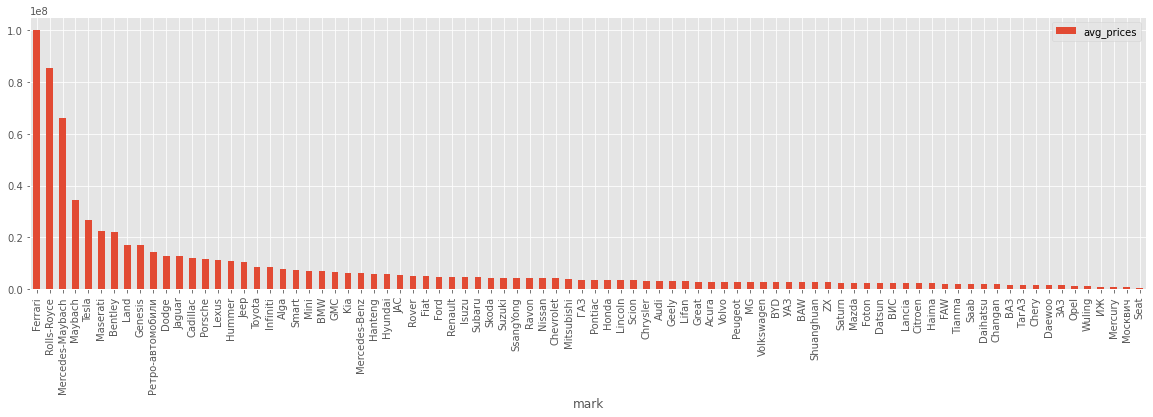

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (20, 5)
data_group.plot(x='mark', y='avg_prices', kind='bar')
#this graph shows from expensive marks to cheap


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


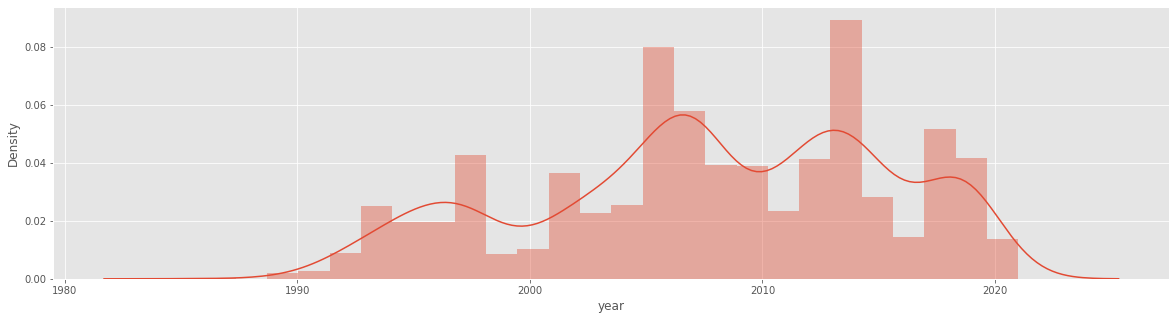

In [ ]:
import seaborn as sns, numpy as np

ax = sns.distplot(toyota.year)
#this graph shows which years Toyota mark sell the most

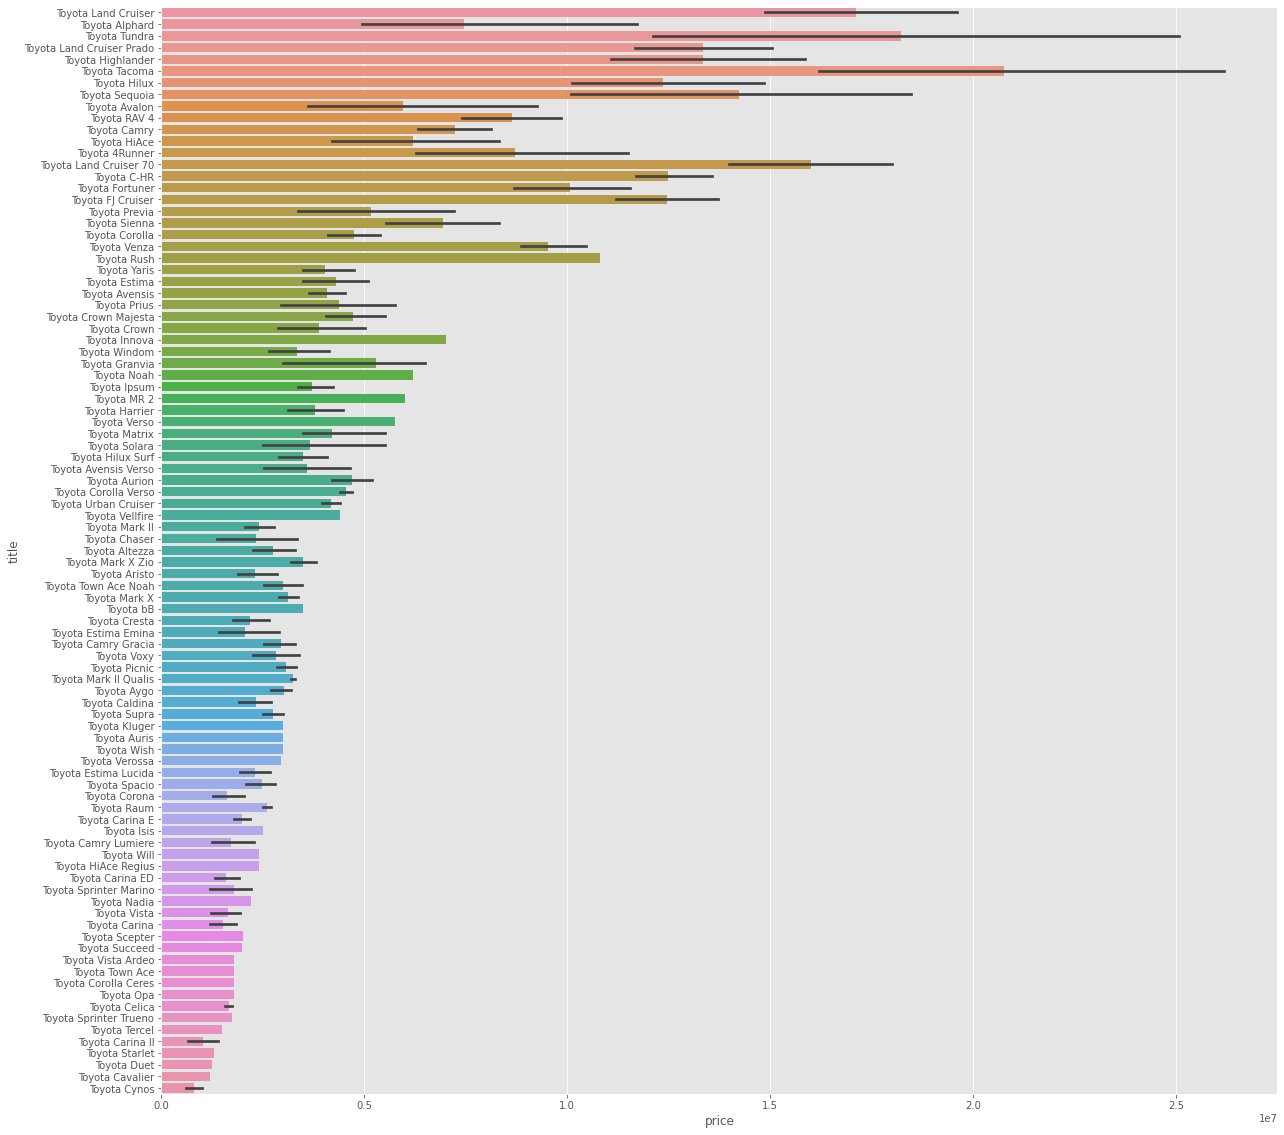

In [ ]:
plt.figure(figsize=(20,20))
ax = sns.barplot(x="price", y="title", data=toyota_max_price)
#this graph shows expensive Toyota models

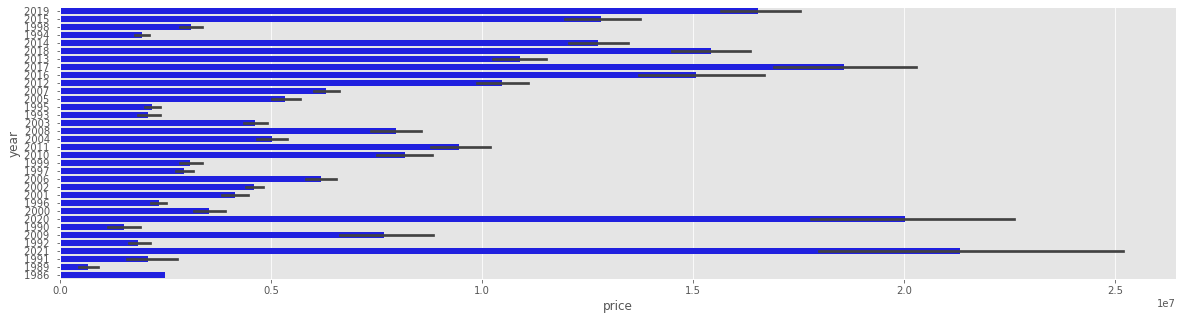

In [ ]:
sns.barplot(x="price", y="year",data=toyota,
            label="Продажа", color="b")
#this graph shows in which years they are expensive

# TOTAL


*   From the analysis of the Toyota mark, we realized that expensive models are mainly  Off-road vehicle, Crossovers and Minivans. From the last chart, it is clear to us that cars from 2017-2021 are considered expensive.

*   Many cars sold from 2000 to 2010.

* The last of the analysis, we realized that expensive models in Kazakhstan are considered the marks Ferarri, Rolls-Royce, Mercedes-Maybach, Maybach and Tesla.